# Step 2, TreeModel_no_service_requests: Create a Random Forest Model to predict street tree falls NOT using service requests
** Note that throughout this and other jupyter notebooks, the following terminology is used:
- falls: refer to fallen branches (from the 311 service request dataset) since 2015
- service requests: refer to 311 service requests for damaged trees or overhanging branches (but NOT fallen branches) since 2015
- tree census: refers to the 2015 NYC Street Tree Census

Packages

In [28]:
# Import packages
%matplotlib inline
import category_encoders as ce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from inspect import signature
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

### Import model data from DataJoin

In [29]:
model_data_df = pd.read_csv('Data/Intermediate/model_data.csv',index_col='tree_id')

C:\Users\brian\.conda\envs\insight\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,18,19,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Edit model data for modeling
Drop service requests and encode categorical data

In [30]:
# Drop service request data
model_data_df.drop(['Branch Cracked and Will Fall','Tree Leaning/Uprooted', 'Hitting Building',
       'Hitting Power/Phone Lines', 'Dead Branches in Tree', 'Blocking Street',
       'Tree Alive - in Poor Condition',],axis=1,inplace=True)

Encode all categorical data

In [31]:
# Encode categorical dataa

# First convert all Yes/No and True/False columns to 1/0
model_data_df.replace({'No': 0, 'Yes': 1},value=None,inplace=True)
model_data_df.replace({False: 0, True: 1},value=None,inplace=True)
model_data_df.replace(np.nan,0,inplace=True)

# Now convert all 2 option columns to 1/0
model_data_df.curb_loc.replace({'OnCurb':1, 'OffsetFromCurb':0},value=None,inplace=True)
model_data_df.sidewalk.replace({'Damage':1, 'NoDamage':0},value=None,inplace=True)
model_data_df.Fall.replace('Branch or Limb Has Fallen Down',1,inplace=True)

# Replace health, steward, and guards columns with numerical levels
model_data_df.health.replace({'Poor':0,'Fair':1,'Good':2},value=None,inplace=True)
model_data_df.steward.replace({'None':0,'1or2':1,'3or4':2,'4orMore':3},value=None,inplace=True)
model_data_df.guards.replace({'Harmful':0,'None':1,'Unsure':2,'Helpful':4},value=None,inplace=True)

# Target encode tree species descriptor data
# First split train and test data to prevent data leakage
df_train, df_test = train_test_split(model_data_df, random_state=1,test_size=0.25)

# Now, target encode training and test data based on training data encoding
target_dict = df_train.groupby('spc_common')['Fall'].mean()
df_train['spc_common'] = df_train['spc_common'].map(target_dict)
df_test['spc_common'] = df_test['spc_common'].map(target_dict)


C:\Users\brian\.conda\envs\insight\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\brian\.conda\envs\insight\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Fit a Random Forest to the features without service requests
Note that parameters were set by gridesearch, gridsearch code was moved to the bottom of the notebook.  The threshold was checked using a precision-recall curve, the code for this was also moved to the bottom of the notebook.

In [32]:
# First set a feature dataframe (x) and a target (y)
x_train = df_train.drop(['zipcode','Fall','address'],axis=1)
y_train = df_train.Fall

In [33]:
# Fit a random forest model
forest = RandomForestClassifier(n_jobs=-1,class_weight='balanced_subsample',random_state = 1, max_depth = 3, n_estimators = 700,criterion='gini')
model = forest.fit(x_train, y_train)

### Find feature importances of the model

Feature ranking:
1. feature heightroof (0.497596)
2. feature tree_dbh (0.214352)
3. feature spc_common (0.161682)
4. feature root_stone (0.037990)
5. feature sidewalk (0.037102)
6. feature curb_loc (0.024781)
7. feature guards (0.008686)
8. feature impervious_pct (0.008528)
9. feature root_other (0.004019)
10. feature steward (0.002294)
11. feature health (0.001569)
12. feature trnk_wire (0.001149)
13. feature trnk_other (0.000166)
14. feature root_grate (0.000054)
15. feature trnk_light (0.000033)


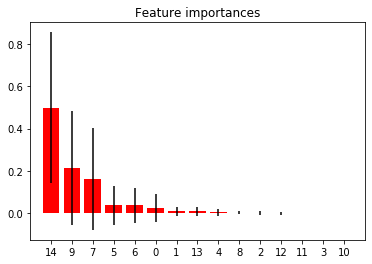

In [34]:
# Check feature importance random forest model
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, x_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

### Check model metrics
Recall is most important to ensure dangerous trees are mantained, we don't want to miss tree branches that will fall!

In [35]:
# Generate target predictions using the random forest model with the specified threshold (0.5 now)
x_test = df_test.drop(['zipcode','Fall','address'],axis=1)
y_test = df_test.Fall
y_pred = (forest.predict_proba(x_test)[:,1] >= 0.5).astype(bool)

In [36]:
# Check accuracy of model on test data
accuracy_score(y_test,y_pred)

0.7202450849309971

In [37]:
# Check ROC-AUC for model on test data
roc_auc_score(y_test,y_pred)

0.7432497231609885

In [38]:
# Check confusion matrix for model on test data
pd.DataFrame(confusion_matrix(y_test, y_pred),
    columns=['Predicted No Fall', 'Predicted Fall'],
    index=['True No Fall', 'True Fall'])

,Predicted No Fall,Predicted Fall
True No Fall,120777,47178
True Fall,946,3121


In [39]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.72      0.83    167955
           1       0.06      0.77      0.11      4067

    accuracy                           0.72    172022
   macro avg       0.53      0.74      0.47    172022
weighted avg       0.97      0.72      0.82    172022



### Generate tree branch fall probabilities from the no service request model
Then save these in an output file

In [40]:
# Calculate Fall probabilities of train and test trees from the no service request model
prob_train = forest.predict_proba(x_train)
prob_test = forest.predict_proba(x_test)

In [41]:
# combine the fall probabilities for the train and test trees, then append to other data to add fall probabilities to the tree census data
df_train['fallprob'] = prob_train[:,1]
df_test['fallprob'] = prob_test[:,1]
tree_branch_fall_prob_df = df_train.append(df_test)

C:\Users\brian\.conda\envs\insight\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\brian\.conda\envs\insight\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
# drop branch fall data from the tree census data with branch fall probabilities
tree_branch_fall_prob_df.drop('Fall',axis=1,inplace=True)

In [43]:
# export data
tree_branch_fall_prob_df.to_csv('Data/FinalOutputs/NoServiceRequestModelOutput.csv')

### Model tuning code
Code from model tuning was moved down here, it doesn't need to be re-run for modeling, and would take some time to run

Gridsearch:

In [9]:
#Try gridsearch to train model on 20% of the data (i.e. 25% of training data) so it doesn't take too long

# First split the training data to a smaller subset for grid search (to run faster)
grid_df, grid_df_valid = train_test_split(df_train, random_state=1,test_size=0.8)

# Set up feature (x) and target (y) data
grid_x = grid_df.drop(['zipcode','Fall','address'],axis=1)
grid_y = grid_df.Fall

# now correct the class imbalance by oversampling the tree branch fall data for the training data 
# Oversample fallen branch data to deal with class imbalance and turn data back into a DataFrame
sm = SMOTE(random_state=1, ratio = 1)

# Random forest model for grid search
grid_forest = imbPipeline([
    ('oversample', SMOTE(random_state=1,ratio=1)),
    ('rf', RandomForestClassifier(random_state = 1))])


# Grid search parameters
n_estimators = [300, 500, 700]
max_depth = [3,5, 10, 30]
max_features = ['auto','sqrt', 'log2']
class_weight = ['balanced', 'balanced_subsample', None]
criterion = ['gini', 'entropy']
hyperF = dict(rf__criterion=criterion,rf__n_estimators = n_estimators, rf__max_depth = max_depth, rf__class_weight=class_weight,rf__max_features=max_features)


# Run grid search
gridF = GridSearchCV(grid_forest, hyperF, scoring = ['recall','f1'], n_jobs = -1,refit='recall')
gridF.fit(grid_x, grid_y)

# Check grid search results
gridF.cv_results_['mean_test_score']

C:\Users\brian\.conda\envs\insight\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.63271625, 0.63348788, 0.63696011, 0.63271625, 0.63348788,
       0.63696011, 0.63271625, 0.63348788, 0.63696011, 0.52932097,
       0.53510797, 0.53742278, 0.52932097, 0.53510797, 0.53742278,
       0.52932097, 0.53510797, 0.53742278, 0.38348767, 0.38464512,
       0.38503091, 0.38348767, 0.38464512, 0.38503091, 0.38348767,
       0.38464512, 0.38503091, 0.11265445, 0.11304024, 0.11458347,
       0.11265445, 0.11304024, 0.11458347, 0.11265445, 0.11304024,
       0.11458347, 0.63503108, 0.63155894, 0.63503117, 0.63503108,
       0.63155894, 0.63503117, 0.63503108, 0.63155894, 0.63503117,
       0.5374228 , 0.53973762, 0.54436722, 0.5374228 , 0.53973762,
       0.54436722, 0.5374228 , 0.53973762, 0.54436722, 0.39004628,
       0.38657404, 0.38734563, 0.39004628, 0.38657404, 0.38734563,
       0.39004628, 0.38657404, 0.38734563, 0.11458349, 0.11458349,
       0.11496929, 0.11458349, 0.11458349, 0.11496929, 0.11458349,
       0.11458349, 0.11496929, 0.63271625, 0.63348788, 0.63696

In [10]:
# See optimal gridsearch parameters
gridF.best_params_

{'rf__class_weight': 'balanced',
 'rf__criterion': 'gini',
 'rf__max_depth': 3,
 'rf__max_features': 'auto',
 'rf__n_estimators': 700}

In [11]:
# Predict validation data
grid_x_valid = grid_df_valid.drop(['zipcode','Fall','address'],axis=1)
grid_y_valid = grid_df_valid.Fall
grid_y_pred = gridF.predict(grid_x_valid)

# check grid search result roc-auc and confusion matrix
roc_auc_score(grid_y_valid,grid_y_pred)

pd.DataFrame(confusion_matrix(grid_y_valid,grid_y_pred),
    columns=['Predicted No Fall', 'Predicted Fall'],
    index=['True No Fall', 'True Fall'])

,Predicted No Fall,Predicted Fall
True No Fall,339766,90150
True Fall,3676,6783


In [12]:
accuracy_score(grid_y_valid,grid_y_pred)

0.7869406755606018

In [13]:
print(classification_report(grid_y_valid,grid_y_pred))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88    429916
           1       0.07      0.65      0.13     10459

    accuracy                           0.79    440375
   macro avg       0.53      0.72      0.50    440375
weighted avg       0.97      0.79      0.86    440375



Text(0.5, 1.0, '2-class Precision-Recall curve')

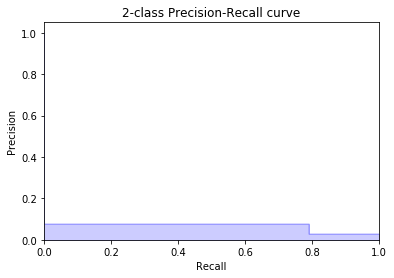

In [13]:
# Check the random forest precision recall curve to look at thresholds

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_train, forest.predict(x_train))

# Plot
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')